Подключение библиотек

In [95]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras import callbacks
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
from pathlib import Path
from os import remove


Загрузка данных

In [63]:
data_row = pd.read_csv("./movies.csv")
data = data_row.drop(columns=["original_language"])
data = data.dropna()
data = data.drop(data[(data.budget == 0) | (data.revenue == 0)].index)
data

,budget,popularity,revenue,vote_average
0,237000000,150.437577,2787965087,7.2
1,300000000,139.082615,961000000,6.9
2,245000000,107.376788,880674609,6.3
3,250000000,112.312950,1084939099,7.6
4,260000000,43.926995,284139100,6.1
...,...,...,...,...
4773,27000,19.748658,3151130,7.4
4788,12000,4.553644,6000000,6.2
4792,20000,0.212443,99000,7.4
4796,7000,23.307949,424760,6.9


Нормализация данных

In [64]:
mm_scalar = preprocessing.MaxAbsScaler()
mm_scalar.fit(data[data.columns[:4]])
norm_data = pd.DataFrame(columns=data.columns[:4], data=mm_scalar.transform(data[data.columns[:4]]))
# norm_data["vote_average"] = pd.DataFrame(data.vote_average.values)
norm_data

,budget,popularity,revenue,vote_average
0,0.623684,0.171815,1.000000,0.847059
1,0.789474,0.158846,0.344696,0.811765
2,0.644737,0.122635,0.315884,0.741176
3,0.657895,0.128272,0.389151,0.894118
4,0.684211,0.050169,0.101916,0.717647
...,...,...,...,...
3224,0.000071,0.022555,0.001130,0.870588
3225,0.000032,0.005201,0.002152,0.729412
3226,0.000053,0.000243,0.000036,0.870588
3227,0.000018,0.026620,0.000152,0.811765


Деление данных на трренировочную и тестовые выборки

In [65]:
X = norm_data[norm_data.columns[:3]]
Y = norm_data[norm_data.columns[3:]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
Y_test

,vote_average
966,0.800000
1603,0.717647
1848,0.423529
195,0.882353
379,0.847059
...,...
691,0.576471
2131,0.694118
621,0.717647
1415,0.847059


Функция для создания контрольных точек

In [78]:
file_name = 'nn_model_loss-{loss:.6f}_val_loss-{val_loss:.6f}.hdf5'
def make_save_points(name='check_points', file_name=file_name):
    checkpoints_dir = Path('./').joinpath(name)
    checkpoints_dir.mkdir(exist_ok=True)
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

Создание сети

In [87]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.tanh, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.sigmoid))
    model.compile(Adam(), 'mse', metrics=['mae'])
    return model

model = make_nn(X_train.shape[1], Y_train.shape[1])

history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=6,
    epochs=100,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(), 
        callbacks.ModelCheckpoint(
            make_save_points(file_name=file_name),
            monitor='val_loss',
            save_best_only=True,
            period=5,
            mode='min'
        )
    ]
    
)

Удаляем файл check_points\nn_model_loss-0.008326_val_loss-0.008253.hdf5
Удаляем файл check_points\nn_model_loss-0.008384_val_loss-0.008301.hdf5
Удаляем файл check_points\nn_model_loss-0.008385_val_loss-0.008313.hdf5
Удаляем файл check_points\nn_model_loss-0.008453_val_loss-0.008317.hdf5
Удаляем файл check_points\nn_model_loss-0.008552_val_loss-0.008458.hdf5
Удаляем файл check_points\nn_model_loss-0.009120_val_loss-0.008768.hdf5
Epoch 1/100
431/431 - 1s - loss: 0.0183 - mae: 0.1069 - val_loss: 0.0096 - val_mae: 0.0765 - 589ms/epoch - 1ms/step
Epoch 2/100
431/431 - 0s - loss: 0.0098 - mae: 0.0779 - val_loss: 0.0091 - val_mae: 0.0740 - 320ms/epoch - 743us/step
Epoch 3/100
431/431 - 0s - loss: 0.0094 - mae: 0.0758 - val_loss: 0.0088 - val_mae: 0.0727 - 306ms/epoch - 710us/step
Epoch 4/100
431/431 - 0s - loss: 0.0091 - mae: 0.0746 - val_loss: 0.0087 - val_mae: 0.0719 - 311ms/epoch - 723us/step
Epoch 5/100
431/431 - 0s - loss: 0.0089 - mae: 0.0739 - val_loss: 0.0086 - val_mae: 0.0719 - 319ms

Вывод графиков ошибки

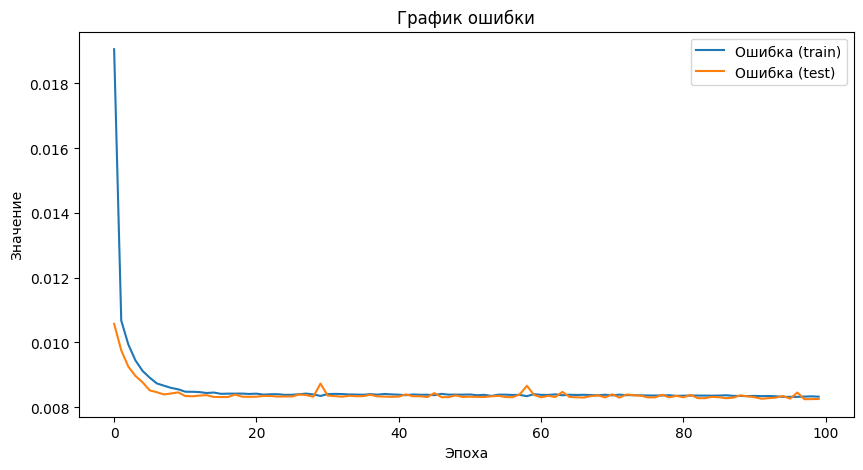

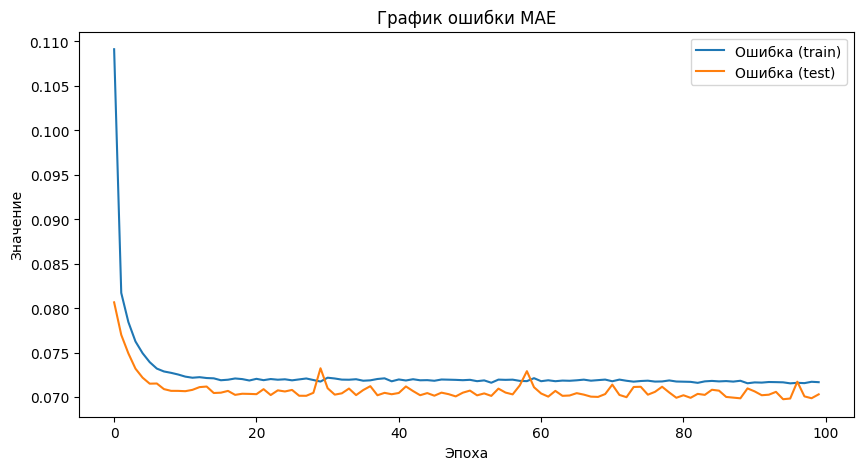

In [86]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(10,5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('График ошибки MAE')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

Вывод метрик последней модели

In [89]:
loss, mae = model.evaluate(X_test, Y_test, verbose=1)
print(loss)
print(mae)

21/21 [==============================] - 0s 657us/step - loss: 0.0082 - mae: 0.0695
0.008198114112019539
0.06950841844081879


Загрузка лучшей модели

In [88]:
from keras.models import load_model

loaded_model = load_model('./check_points/nn_model_loss-0.008230_val_loss-0.008194.hdf5')

Вывод метрик лучшей модели

In [90]:
loss, mae = loaded_model.evaluate(X_test, Y_test, verbose=1)
print(loss)
print(mae)

21/21 [==============================] - 0s 744us/step - loss: 0.0082 - mae: 0.0696
0.00819415133446455
0.06963398307561874


Сравнение реальных и предсказанных данных

In [91]:
predicted = pd.DataFrame(loaded_model.predict(X_test), columns=['predicted'])
predicted["real"] = pd.DataFrame(Y_test.reset_index(drop=True))
predicted


21/21 [==============================] - 0s 499us/step


,predicted,real
0,0.768223,0.800000
1,0.742372,0.717647
2,0.720179,0.423529
3,0.867953,0.882353
4,0.776251,0.847059
...,...,...
641,0.707890,0.576471
642,0.755179,0.694118
643,0.719431,0.717647
644,0.756739,0.847059


Проекция данных на двухмерную ось

21/21 [==============================] - 0s 501us/step


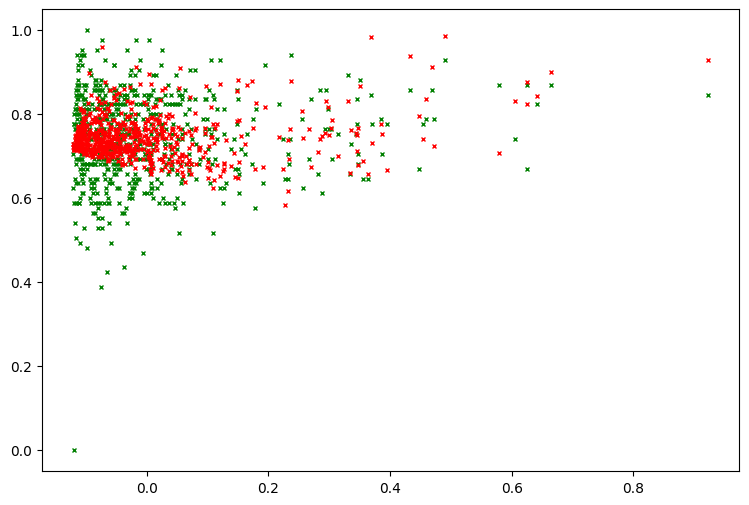

In [101]:
pca = PCA(n_components=1).fit(X_test)
fig, ax = plt.subplots(figsize=(9, 6))

pca_x = pca.transform(X_test)

ax.plot(pca_x, Y_test, 'gx', markersize=3)
ax.plot(pca_x, loaded_model.predict(X_test), 'rx', markersize=3)
# ax.grid()

Сравнение ненормализованных данных

In [133]:
X_test = pd.DataFrame(X_test.reset_index(drop=True))
Y_test = pd.DataFrame(Y_test.reset_index(drop=True))
real_reverse = pd.DataFrame(mm_scalar.inverse_transform(X_test.join(Y_test)), columns=data.columns)
real_reverse

,budget,popularity,revenue,vote_average
0,46000000.0,41.322708,113714830.0,6.8
1,26000000.0,22.520842,29657751.0,6.1
2,20000000.0,10.098722,48548426.0,3.6
3,125000000.0,109.984351,976475550.0,7.5
4,75000000.0,53.213931,288500217.0,7.2
...,...,...,...,...
641,60000000.0,20.501582,163403799.0,4.9
642,15000000.0,21.095489,75700498.0,5.9
643,70000000.0,26.199090,255000211.0,6.1
644,30000000.0,26.952727,160638883.0,7.2


In [132]:
predicted_reverse = pd.DataFrame(mm_scalar.inverse_transform(X_test.join(pd.DataFrame(predicted["predicted"]))), columns=data.columns)
predicted_reverse

,budget,popularity,revenue,vote_average
0,46000000.0,41.322708,113714830.0,6.529897
1,26000000.0,22.520842,29657751.0,6.310158
2,20000000.0,10.098722,48548426.0,6.121518
3,125000000.0,109.984351,976475550.0,7.377601
4,75000000.0,53.213931,288500217.0,6.598134
...,...,...,...,...
641,60000000.0,20.501582,163403799.0,6.017061
642,15000000.0,21.095489,75700498.0,6.419017
643,70000000.0,26.199090,255000211.0,6.115163
644,30000000.0,26.952727,160638883.0,6.432286
